## **Mister_med**:
#### This is a fine-tuned LLM on top of Mistral-7b for Q/A Disease and Disease symptoms

Dataset Link: https://huggingface.co/datasets/prognosis/symptoms_disease_v1/viewer/default/train?p=2

#### Installing the required Libraries

In [1]:
# run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U pandas
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 32.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.18.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.4 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencie

In [2]:
from datasets import load_dataset, DatasetDict, Dataset
import pandas as pd
import datasets
import time

#### Load data set from huggingface

In [3]:
train_dataset = load_dataset("prognosis/symptoms_disease_v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'instruction', 'reference', 'output'],
        num_rows: 10110
    })
})

Support for third party widgets will remain active for the duration of the session. To disable support:

In [5]:
eval_dataset = load_dataset('json', data_files='/content/eval_dataset.json', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
eval_dataset

Dataset({
    features: ['input', 'instruction', 'reference', 'output'],
    num_rows: 87
})

In [7]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [8]:
# Convert to a pandas dataframe
data = [{'instruction': item['instruction'],'output': item['output']} for item in train_dataset['train']]
df = pd.DataFrame(data)

In [9]:
# Just extract the outputs
df['output'] = df['output'].apply(lambda x: ', '.join(x.split(', ')))
display(df.head())

,instruction,output
0,What are the symptoms of hypertensive disease?,The following are the symptoms of hypertensive...
1,I am having the following symptoms: pain ches...,The symptoms listed indicates that the patient...
2,What are the symptoms of diabetes?,The following are the symptoms of diabetes: po...
3,"I am having the following symptoms: polyuria, ...",The symptoms listed indicates that the patient...
4,What are the symptoms of depressive disorder?,The following are the symptoms of depressive d...


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('instruction').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('output').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['output'].value_counts()
    for x_label, grp in _df_2.groupby('instruction')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('instruction')
_ = plt.ylabel('output')

In [10]:
df.describe()

,instruction,output
count,10110,10110
unique,615,615
top,What are the symptoms of Chicken pox?,The symptoms listed indicates that the patient...
freq,120,120


In [ ]:
# for Multiple GPUs

# from accelerate import FullyShardedDataParallelPlugin, Accelerator
# from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

# fsdp_plugin = FullyShardedDataParallelPlugin(
#     state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
#     optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
# )

# accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### Loading the Mistral 7B model in quantized format

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [12]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))
def formatting_func(row):
    text = f"### Question: {row['instruction']}\n ### Answer: {row['output']}"
    return text

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [13]:
tokenized_train_dataset = train_dataset['train'].map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/10110 [00:00<?, ? examples/s]

Map:   0%|          | 0/87 [00:00<?, ? examples/s]

10197


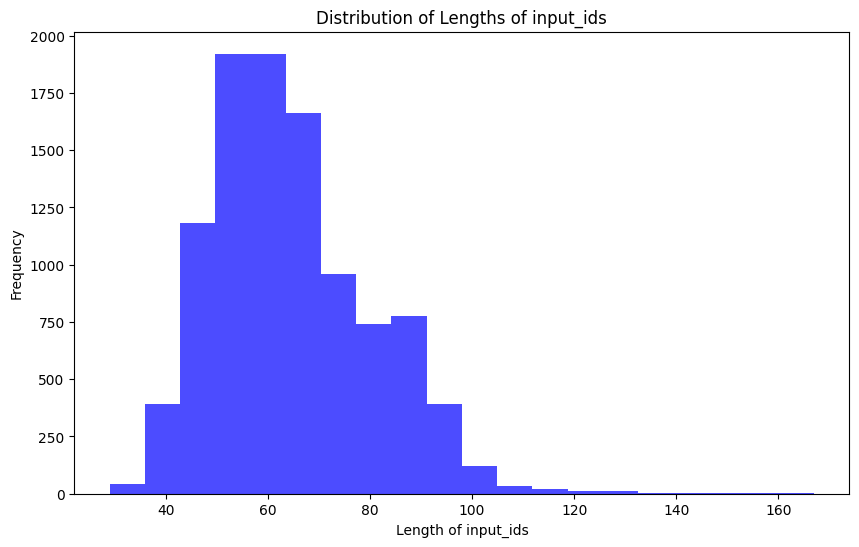

In [14]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [15]:
max_length = 512

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [16]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/10110 [00:00<?, ? examples/s]

Map:   0%|          | 0/87 [00:00<?, ? examples/s]

In [17]:
tokenized_train_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'instruction', 'reference', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10110
    })
})

In [18]:
print(tokenized_train_dataset['train'][1])

{'input': '', 'instruction': 'I am having the following symptoms: pain  chest, shortness  of breath, dizziness, asthenia, fall, syncope, vertigo, sweating  increased, palpitation, nausea, angina  pectoris, pressure  chest. What could be the disease ?', 'reference': '', 'output': 'The symptoms listed indicates that the patient is dealing with hypertensive  disease.', 'input_ids': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

10197


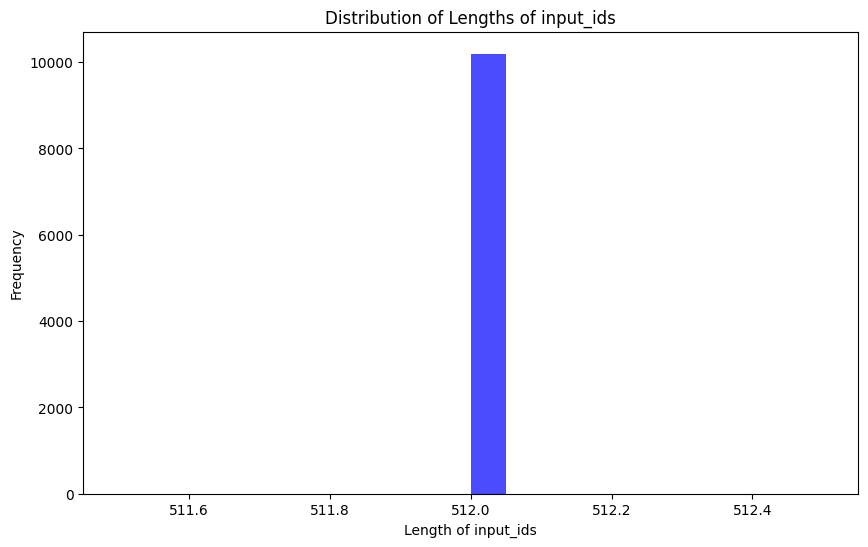

In [19]:
plot_data_lengths(tokenized_train_dataset['train'], tokenized_val_dataset)

#### Generating the output from Base Model

In [20]:
eval_prompt = """ Given the following Symptoms of a person's disease, What could be the Disease ?

### Symptoms:
diarrhea, vomiting, hypotension, nausea, lightheadedness, unwell, mental status changes, anorexia, asthenia, sensory discomfort, syncope, lethargy, dizziness, history  of - blackout.

### Disease:
"""

In [21]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Given the following Symptoms of a person's disease, What could be the Disease ?

### Symptoms:
diarrhea, vomiting, hypotension, nausea, lightheadedness, unwell, mental status changes, anorexia, asthenia, sensory discomfort, syncope, lethargy, dizziness, history  of - blackout.

### Disease:

##### Hyponatremia

Hyponatremia is defined as serum sodium concentration less than 135 mmol/L (135 mEq/L). It is one of the most common electrolyte disorders in hospitalized patients and can occur in any clinical setting. The prevalence of hyponatremia varies widely depending on the population studied and the definition used to define hyponatremia. In general, it occurs in approximately 20% of hospitalized patients.

The pathophysiology of hyponatremia involves a complex interplay between water intake, water excretion, and sodium balance. Water intake is regulated by thirst, which is stimulated by osmotic receptors in the anterior hypothalamus that are sensitive to plasma osmolality. Thirst is al

### Setup QLoRA

In [22]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [23]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [24]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [25]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [26]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

### Training the additional adapter weights

In [27]:
torch.cuda.is_available()

True

In [ ]:
# If more than 1 GPU

# if torch.cuda.device_count() > 1:
#     model.is_parallelizable = True
#     model.model_parallel = True
# model = accelerator.prepare_model(model)

In [28]:
torch.cuda.device_count()

1

In [33]:
import transformers
from datetime import datetime

project = "mister-med-finetuned"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset['train'],
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        # use_bfloat16=False,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=125,
        learning_rate=2.5e-5,
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps",
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.299400,2.018655
50,0.745300,1.874522
75,0.490500,1.989537
100,0.353400,2.047854
125,0.374600,2.027010


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:133: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:133: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=125, training_loss=0.6526327056884765, metrics={'train_runtime': 908.7365, 'train_samples_per_second': 0.275, 'train_steps_per_second': 0.138, 'total_flos': 5526298558464000.0, 'train_loss': 0.6526327056884765, 'epoch': 0.02})

### Trying the trained Model

In [34]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/mistral-mister-med-finetuned/checkpoint-100")

In [45]:
eval_prompt = " I have the symptoms: diarrhea, vomiting, hypotension, nausea, lightheadedness, unwell, mental status changes, anorexia, asthenia, sensory discomfort, syncope, lethargy, dizziness, what could be the disease?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=512, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 I have the symptoms: diarrhea, vomiting, hypotension, nausea, lightheadedness, unwell, mental status changes, anorexia, asthenia, sensory discomfort, syncope, lethargy, dizziness, what could be the disease?
 ###

### Symptoms Description: ###
The following are the symptoms with related conditions:

### Diagnosis: ###
The clinical diagnosis is: Gastroenteritis.

Gastroenteritis is a condition in which the stomach and intestines get inflamed. The symptoms of gastroenteritis include abdominal pain, vomiting, headache, high fever, malaise, loss of appetite, nausea, mild fever, chills, constipation, cough, chest pain, breathlessness, bladder discomfort, spotting while urination, continuous feel of urine, obesity, family history, history of chronic alcohol consumption, fatigue, mood swings, irritability, depression, visual disturbances, stiff neck, excessive hunger, slurred speech, altered sensorium, irritation in eyes, sunken eyes, dehydration, fluid overload, distention of abdomen, swelle

In [38]:
eval_prompt = "What are the symptoms of coronary heart disease? "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


What are the symptoms of coronary heart disease?  The following are the symptoms of coronary heart disease: chest pain, fatigue, sweating, breathlessness, palpitations, family history, obesity, diabetes, smoking.
 ###
###
What are the causes of coronary heart disease? The following are the causes of coronary heart disease: high cholesterol, hypertension, diabetes, obesity, smoking, alcohol, stress, lack of exercise.
 ###
###
What are the risk factors of coronary heart disease? The following are the risk factors of coronary heart disease: high cholesterol, hypertension, diabetes, obesity, smoking, alcohol, stress, lack of exercise.
 ###
###
What are the complications of coronary heart disease? The following are the complications of coronary heart disease: angina, myocardial infraction, congestive cardiac failure, arrhythmias, stroke.
 ###
###



## Comparing the original dataset with the model output on the same instruction.

In [47]:
df.head(1)

,instruction,output
0,What are the symptoms of hypertensive disease?,The following are the symptoms of hypertensive...


In [52]:
eval_prompt = "What are the symptoms of hypertensive  disease?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=70, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


What are the symptoms of hypertensive  disease?
 ### The following are the symptoms of hypertensive  disease: vomiting, headache, blurred and distorted vision, excessive hunger, dizziness, obesity, anxiety, irritability, lethargy, depression, visual disturbances, palpitations, chest pain, sweating, breathlessness, fatigue.


### Conclusion: The Model output is somewhat good, but not reliable. This may be due to overfitting and using the less precision (fp16) during training and finetuning and less training steps.